In [1]:
import pandas as pd
import pickle
import numpy as np

from tqdm import tqdm

## 데이터 읽어오기

In [13]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
train_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [14]:
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


## time delta 계산

In [3]:
def get_timedelta(df):
    # Daily mission 방식대로 계산하면 testId 경계 부분에서 마지막 문제 값이 너무 크게 계산되므로
    # groupby 에서 testId 도 포함
    diff = df.loc[:, ['userID', 'Timestamp', 'testId']].groupby(['userID','testId']).diff().shift(-1).fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    return diff

In [ ]:
# df['elapsed'] = diff

# elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
# elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [7]:
diff = get_timedelta(train_df)

In [12]:
diff = diff.rename('elapsed')
diff.head()

0     3.0
1     8.0
2     7.0
3     7.0
4    11.0
Name: elapsed, dtype: float64

In [15]:
train_df['elapsed'] = diff
train_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,11.0


In [16]:
with open('/opt/ml/input/data/train_dataset/train_timedelta.bin', 'wb') as f:
    pickle.dump(train_df, f)

In [5]:
with open('/opt/ml/input/data/train_dataset/train_timedelta.bin', 'rb') as f:
    train_df = pickle.load(f)

## 결측치 파악

In [20]:
stu_groupby = train_df.groupby(['userID', 'testId']).agg({
    'assessmentItemID': ['count', pd.Series.nunique],
})

stu_groupby.head()

assessmentItemID        
                             count nunique
userID testId                             
0      A020000172                6       6
       A020000174                5       5
       A020000181                6       6
       A020000182                5       5
       A020000183                7       7

In [24]:
multi_sol = stu_groupby[stu_groupby['assessmentItemID']['count'] != stu_groupby['assessmentItemID']['nunique']]
multi_sol.head()

assessmentItemID        
                             count nunique
userID testId                             
1      A040000155               12       6
       A040000156               12       6
       A040000157               12       6
       A040000158               12       6
       A040000160               10       5

<AxesSubplot:ylabel='Frequency'>

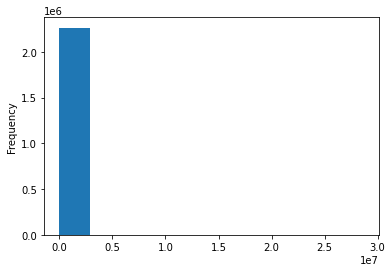

In [19]:
diff.plot.hist()

In [29]:
# pure 하게 문제 푼 시간 아니라고 판단

threshold_minutes = 15

too_long = diff[diff > threshold_minutes * 60]
print(len(too_long))
too_long.head()

28369


356    2349.0
619    3998.0
686    1116.0
752    1688.0
762    2171.0
Name: elapsed, dtype: float64

In [30]:
diff[diff > threshold_minutes * 60] = 0

In [31]:
diff[350:360]

350     11.0
351     99.0
352     43.0
353      0.0
354    111.0
355     68.0
356      0.0
357     22.0
358     21.0
359     10.0
Name: elapsed, dtype: float64

350     11.0
351     99.0
352     43.0
353      0.0
354    111.0
355     68.0
356      0.0
357     22.0
358     21.0
359     10.0
Name: elapsed, dtype: float64


<AxesSubplot:ylabel='Frequency'>

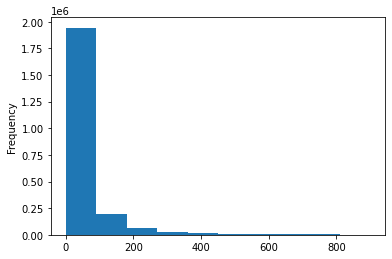

In [32]:
train_df['elapsed'] = diff
print(train_df['elapsed'][350:360])
train_df['elapsed'].plot.hist()

## 결측치를 대체할 값들
- 맞았을 때, 틀렸을 때 걸린 시간 따로 기록하기
- 시험지의 마지막 문항이라면 user 가 누구든 time delta 가 0 으로 예측되므로 user 고유의 특성 (풀이 시간) 들어가면 좋겠음
    - 동일 user, knowledgeTag, answerCode 일 때 걸린 평균 시간
- 그게 아니라 그냥 time delta 가 문제를 pure 하게 풀었다기에 너무 길면, 같은 answerCode 를 낸 다른 user 가 걸렸던 평균 시간으로 대체

In [34]:
def nonzero_mean(s):
    num_nonzero = len(s.to_numpy().nonzero()[0])

    if num_nonzero == 0:
        return 0

    return np.sum(s) / num_nonzero

In [56]:
nonzero_mean(pd.Series([0,0,0]))

0

In [39]:
# 동일 assessmentItemID 에서 다른 사용자가 걸린 시간
def get_time_per_question(df):
    tag_groupby = df.groupby(['assessmentItemID', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [44]:
# 동일 사용자, knowledgeTag 에서 걸린 시간
def get_time_per_user_tag(df):
    tag_groupby = df.groupby(['userID', 'KnowledgeTag', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [35]:
# 동일 KnowledgeTag 에서 다른 사용자가 걸린 시간
def get_time_per_tag(df):
    tag_groupby = df.groupby(['KnowledgeTag', 'answerCode']).agg({
        'elapsed': nonzero_mean
    })

    return tag_groupby

In [40]:
t = get_time_per_question(train_df)

In [37]:
zero_sol = train_df[train_df['elapsed'] == 0]
print(len(zero_sol))
zero_sol.head()

400903


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,0.0
12,0,A060003007,A060000003,1,2020-03-26 05:54:11,7226,0.0
19,0,A060005007,A060000005,1,2020-03-31 05:05:48,7228,0.0
26,0,A060007007,A060000007,1,2020-04-02 05:04:08,7229,0.0
32,0,A080002006,A080000002,1,2020-04-06 00:38:05,1395,0.0


In [76]:
# example = train_df.loc[(train_df['userID'] == 0) & (train_df['assessmentItemID'] == 'A060001007') & (train_df['testId'] == 'A060000001')]

# if not example.empty:
#     print(example['elapsed'].values)

[0.]


In [42]:
for index, row in tqdm(zero_sol.iterrows()):

    # Get replacement
    aid = row['assessmentItemID']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t.loc[(aid, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t.loc[(aid, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        zero_sol.at[index, ['elapsed']] = (replace_elapsed)

1it [00:01,  1.90s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
400903it [25:01, 267.07it/s]


In [46]:
# Any zeros left?
unresolved = zero_sol[zero_sol['elapsed'] == 0]
print(len(unresolved))

25916


In [45]:
t2 = get_time_per_user_tag(train_df)

In [47]:
t2.head()

elapsed
userID KnowledgeTag answerCode           
0      23           0           10.666667
       25           0            3.000000
       26           0            6.333333
                    1           27.000000
       30           0           30.000000

In [48]:
for index, row in tqdm(unresolved.iterrows()):

    # Get replacement
    uid = row['userID']
    tag = row['KnowledgeTag']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t2.loc[(uid, tag, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t2.loc[(uid, tag, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        unresolved.at[index, ['elapsed']] = (replace_elapsed)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
25916it [00:44, 585.86it/s]


In [50]:
zero_sol.update(unresolved)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [51]:
print(len(zero_sol[zero_sol['elapsed'] == 0]))

unresolved = zero_sol[zero_sol['elapsed'] == 0]
unresolved.head()

3163


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
76,0.0,A060020007,A060000020,0.0,2020-04-23 01:46:43,590.0,0.0
583,0.0,A080098008,A080000098,0.0,2020-10-06 19:25:32,1120.0,0.0
727,0.0,A080120006,A080000120,0.0,2020-11-18 03:10:22,1201.0,0.0
3160,6.0,A040168005,A040000168,0.0,2020-08-18 13:27:38,2118.0,0.0
4377,7.0,A020116005,A020000116,0.0,2020-09-24 01:43:48,8006.0,0.0


In [52]:
t3 = get_time_per_tag(train_df)

In [53]:
for index, row in tqdm(unresolved.iterrows()):

    # Get replacement
    tag = row['KnowledgeTag']
    answer = row['answerCode']
    replace_elapsed = 0

    # groupby with multiindex
    replace = t3.loc[(tag, answer)]
    if not replace.empty:
        replace_elapsed = replace['elapsed']
    else:
        # answerCode 가 다르더라도 푼 적이 있으면
        replace = t3.loc[(tag, (answer+1) % 2)]
        if not replace.empty:
            replace_elapsed = replace['elapsed']

    if replace_elapsed > 0:
        unresolved.at[index, ['elapsed']] = (replace_elapsed)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
3163it [00:06, 492.03it/s]


In [54]:
print(len(unresolved[unresolved['elapsed'] == 0]))


0


In [55]:
zero_sol.update(unresolved)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [56]:
print(len(zero_sol))
print(len(zero_sol[zero_sol['elapsed'] == 0]))

400903
0


In [57]:
train_df.update(zero_sol)

In [58]:
print(len(train_df[train_df['elapsed'] == 0]))

0


In [59]:
with open('/opt/ml/input/data/train_dataset/train_timedelta_replaced.bin', 'wb') as f:
    pickle.dump(train_df, f)

In [ ]:
train_df.to_csv('/opt/ml/input/data/train_dataset/train_timedelta_replaced.csv', sep=',')

## 기타

In [34]:
# 정답은 1, 오답은 0 이라 sum 을 전체 개수로 나눈 것이 정답률

def percentile(s):
    return np.sum(s) / len(s)

In [9]:
# 문항별 정답률
def get_score_per_question(df):
    prob_groupby = df.groupby('assessmentItemID').agg({
        'userID': pd.Series.nunique,  # 'count'
        'answerCode': percentile
    })

    return prob_groupby

In [10]:
# 시험지별 정답률
def get_score_per_test(df):
    test_groupby = df.groupby('testId').agg({
        'userID': pd.Series.nunique,  # 'count'
        'answerCode': percentile
    })

    return test_groupby